In [1]:
# import
import os, sys
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.spatial import distance
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from tqdm import tqdm

# import plotting libraries
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 8})
plt.rcParams["svg.fonttype"] = "none"
import seaborn as sns
from nilearn import datasets
from nilearn import plotting

sys.path.extend([r'/home/lindenmp/research_projects/snaplab_tools'])
sys.path.extend([r'/home/lindenmp/research_projects/nctpy/src'])

# import nctpy functions
from nctpy.energies import integrate_u, get_control_inputs
from nctpy.pipelines import ComputeControlEnergy, ComputeOptimizedControlEnergy
from nctpy.metrics import ave_control
from nctpy.utils import (
    matrix_normalization,
    convert_states_str2int,
    normalize_state,
    normalize_weights,
    get_null_p,
    get_fdr_p,
)
from nctpy.plotting import roi_to_vtx, null_plot, surface_plot, add_module_lines
from null_models.geomsurr import geomsurr
from snaplab_tools.plotting.plotting import brain_scatter_plot
from snaplab_tools.plotting.utils import get_my_colors
from snaplab_tools.utils import get_schaefer_system_mask

# Load data

In [2]:
# directory where data is stored
indir = '/home/lindenmp/research_projects/nct_xr/data'
outdir = '/home/lindenmp/research_projects/nct_xr/results'
fmri_concat = np.load(os.path.join(outdir, 'fmri_clusters_fmri_concat.npy'))
fmri_concat_subjidx = np.load(os.path.join(outdir, 'fmri_clusters_fmri_concat_subjidx.npy'))

In [3]:
# extract cluster centers. These represent dominant patterns of recurrent activity over time
parc_centroids = pd.read_csv(os.path.join(indir, 'schaefer400-7_centroids.csv'), index_col=0)
parc_centroids.head()

,R,A,S
ROI Name,,,
7Networks_LH_Vis_1,-33,-42,-21
7Networks_LH_Vis_2,-30,-33,-18
7Networks_LH_Vis_3,-36,-62,-17
7Networks_LH_Vis_4,-24,-55,-8
7Networks_LH_Vis_5,-23,-73,-10


In [4]:
# check number of clusters
# inertia_o = np.square((fmri_concat - fmri_concat.mean(axis=0))).sum()
# alpha_k = 0.005
k_range = range(2, 20)
inertia = []
# silhouette_avg = []
for k in k_range:
    fmri_clusters_file = 'hcp_fmri_clusters_k-{0}.npy'.format(k)
    fmri_clusters = np.load(os.path.join(outdir, fmri_clusters_file), allow_pickle=True).item()
    inertia_k = fmri_clusters['inertia']
    # scaled_inertia = (inertia_k / inertia_o) + (alpha_k * k)
    # inertia.append(scaled_inertia)
    inertia.append(inertia_k)

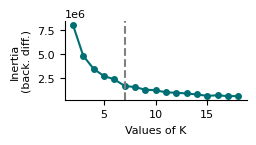

In [5]:
my_colors = get_my_colors()
f, ax = plt.subplots(1, 1, figsize=(2.5, 1.5))
ax.plot(k_range[:-1], np.abs(np.diff(inertia)), c=my_colors['north_sea_green'], marker='o', markersize=4)
# ax.set_xticks(k_range)
ax.set_xlabel('Values of K') 
ax.set_ylabel('Inertia\n(back. diff.)') 
ax.axvline(x=7, linestyle='--', c='gray')
sns.despine(ax=ax)

f.tight_layout()
plt.show()
f.savefig(os.path.join(outdir, "inertia.svg"), dpi=600, bbox_inches="tight", pad_inches=0.01)

In [6]:
# load rsfMRI clusters
k = 7
fmri_clusters_file = 'hcp_fmri_clusters_k-{0}.npy'.format(k)
fmri_clusters = np.load(os.path.join(outdir, fmri_clusters_file), allow_pickle=True).item()
print(fmri_clusters.keys())
centroids = fmri_clusters['centroids']
labels = fmri_clusters['labels']
n_states = centroids.shape[0]
n_labels = labels.shape[0]
print('n_states, {0}; n_labels, {1}'.format(n_states, n_labels))

dict_keys(['centroids', 'labels', 'inertia', 'centroid_subj_frac', 'variance_explained'])
n_states, 7; n_labels, 873600


In [7]:
state_subj_frac = []
for i in np.arange(n_states):
    state_subj_frac.append(len(np.unique(fmri_concat_subjidx[labels == i])) / len(np.unique(fmri_concat_subjidx)))
state_subj_frac

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

# Plots

### Brain states: scatter

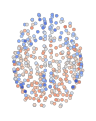

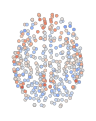

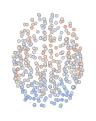

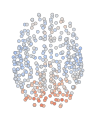

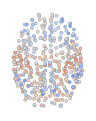

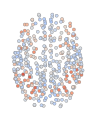

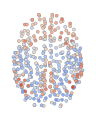

In [8]:
for state_idx in np.arange(n_states):
    f = brain_scatter_plot(parcel_coords=parc_centroids, node_data=centroids[state_idx, :], vmin=-1.25, vmax=1.25, cmap='coolwarm')
    f.savefig(os.path.join(outdir, "k-{0}_cluster_{1}.png".format(n_states, state_idx)), dpi=600, bbox_inches="tight", pad_inches=0.01)

### Brain states: correlations between states

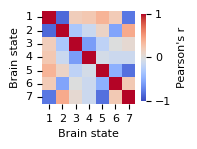

In [9]:
brain_state_corr = np.zeros((n_states, n_states))
for state_i in np.arange(n_states):
    for state_j in np.arange(n_states):
        brain_state_corr[state_i, state_j] = sp.stats.pearsonr(centroids[state_i, :], centroids[state_j, :])[0]
        
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))

sns.heatmap(brain_state_corr, square=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, cbar_kws={'shrink': 0.75, 'label': 'Pearson\'s r'})
ax.set_xlabel('Brain state')
ax.set_ylabel('Brain state')

x_tick_labels = []
for tick in ax.get_xticklabels():
    x_tick_labels.append(int(tick.get_text()) + 1)
ax.set_xticklabels(x_tick_labels, rotation=0)
y_tick_labels = []
for tick in ax.get_yticklabels():
    y_tick_labels.append(int(tick.get_text()) + 1)
ax.set_yticklabels(y_tick_labels, rotation=0)

f.savefig(os.path.join(outdir, "brain_state_correlation.svg".format(n_states, state_idx)), dpi=600, bbox_inches="tight", pad_inches=0.01)

### Brain states: correspondence with canonical systems

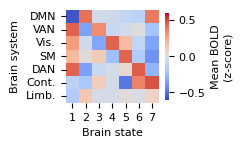

In [10]:
yeo_systems = ['Default', 'SalVentAttn', 'Vis', 'SomMot', 'DorsAttn', 'Cont', 'Limbic'] # k = 7
yeo_systems_labels = ['DMN', 'VAN', 'Vis.', 'SM', 'DAN', 'Cont.', 'Limb.'] # k = 7
n_systems = len(yeo_systems)
mean_activity = np.zeros((n_systems, n_states))
for system_idx in np.arange(n_systems):
    system_mask = get_schaefer_system_mask(parc_centroids.index, system=yeo_systems[system_idx])
    for state_idx in np.arange(n_states):
        mean_activity[system_idx, state_idx] = centroids[state_idx, system_mask].mean()
        
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))

sns.heatmap(mean_activity, square=True, cmap='coolwarm', center=0, vmin=-0.6, vmax=0.6, cbar_kws={'shrink': 0.75, 'label': 'Mean BOLD\n(z-score)'})
ax.set_xlabel('Brain state')
ax.set_ylabel('Brain system')

x_tick_labels = []
for tick in ax.get_xticklabels():
    x_tick_labels.append(int(tick.get_text()) + 1)
ax.set_xticklabels(x_tick_labels, rotation=0)
ax.set_yticklabels(yeo_systems_labels, rotation=0)
f.savefig(os.path.join(outdir, "brain_state_system_mapping.svg".format(n_states, state_idx)), dpi=600, bbox_inches="tight", pad_inches=0.01)